# Model Performance


In [63]:
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, KFold, cross_validate, cross_val_predict
from random import randint
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning # Import ConvergenceWarning
from joblib import parallel_backend
from xgboost import XGBRegressor


In [2]:
df = pd.read_excel('updated_DATASET.xlsx', engine="openpyxl")


In [3]:
new_columns = ['TemP (K)', 'PS (mm)', 'BET (m2/g)', 'PV (cm3)', 'C (wt.%)', 'H  (wt.%)', 'N  (wt.%)', 'O  (wt.%)', 'TP_Ciprofloxacin', 'TP_Tetracycline', 'TP_Tetracycline']
X = df.drop(['Qm (mg/g)', 'C (wt.%)', 'H  (wt.%)', 'PS (mm)'], axis =1)  # Features
y = df['Qm (mg/g)']  # Target

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']


## Random Forest Regressor(GridSearchCV)

In [6]:
# Define the parameter grid to search through
rf_regressor = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [15, 25, 50, 100, 150],
    'max_depth': [None, 6, 8],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV with cross-validation on the training set
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid,
                           scoring=scoring, refit="neg_mean_squared_error", cv=5, verbose=1, n_jobs=-1, return_train_score=False)

# Perform the grid search on the training set
grid_search.fit(X_train, y_train)

# Extract the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters: ", best_params)

# Extract cross-validation results
cv_results = pd.DataFrame(grid_search.cv_results_)

# # Extract R-squared and MAE from cross-validation results
# cv_results['mean_test_r2'] = cv_results['mean_test_score']
# cv_results['mean_test_mae'] = -cv_results['mean_test_score']  # MAE is positive, so negate back

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Hyperparameters:  {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [7]:
rf_r2 = cv_results[f'mean_test_r2'] *-1
mean_rf_r2 = rf_r2.mean()
rf_mae = cv_results[f'mean_test_neg_mean_absolute_error'] * -1
mean_rf_mae = rf_mae.mean()
rf_rmse = np.sqrt(cv_results[f'mean_test_neg_mean_squared_error'] * -1)
mean_rf_rmse = rf_rmse.mean()

In [8]:
k_folds = KFold(n_splits = 5)
rf_mae = cross_val_score(grid_search.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_absolute_error") * -1
rf_r2 = cross_val_score(grid_search.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "r2")
rf_rmse = np.sqrt(cross_val_score(grid_search.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")*-1)

In [9]:
best_params_rf = grid_search.best_params_

In [10]:
#untuned cross validation
default_rf = RandomForestRegressor(random_state=42)
k_folds = KFold(n_splits = 5)

untuned_mae_result = cross_val_score(default_rf, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_absolute_error")
untuned_rmse_result = cross_val_score(default_rf, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")
untuned_r2_result = cross_val_score(default_rf, X, y.values.ravel(), cv = k_folds, scoring= "r2")

In [11]:
untuned_r2_result

array([-13.51033113,   0.03031668,   0.16901228,   0.11468819,
        -0.14771031])

In [12]:
average_untuned_mae_rf = np.mean(untuned_mae_result) *-1
average_untuned_rmse_rf = np.mean(np.sqrt(untuned_rmse_result*-1))
average_untuned_r2_rf = np.mean(untuned_r2_result)


In [13]:
rf_results = {
    "Tunned": {"r2": rf_r2, "rmse": rf_rmse, "mae": rf_mae},
    "Untunned": {"r2": untuned_r2_result, "rmse": np.sqrt(untuned_rmse_result*-1), "mae": untuned_mae_result *-1}
}

In [14]:
rf_results

{'Tunned': {'r2': array([-13.1135064 ,   0.02617144,   0.19193869,   0.08906365,
          -0.22094096]),
  'rmse': array([34.29333577, 53.82705822, 64.14303921, 34.71145665, 71.06530507]),
  'mae': array([25.27638262, 39.20421766, 37.51915947, 20.59582001, 61.479146  ])},
 'Untunned': {'r2': array([-13.51033113,   0.03031668,   0.16901228,   0.11468819,
          -0.14771031]),
  'rmse': array([34.7721009 , 53.7123747 , 65.04661186, 34.21975931, 68.90114443]),
  'mae': array([24.29171287, 39.29294938, 37.57649281, 19.79182013, 58.84040106])}}

In [64]:
def visualize(dataframe, model):
    records = []
    for category, metrics in dataframe.items():
        for metric, values in metrics.items():
            for value in values:
                records.append([category, metric, value])

    df = pd.DataFrame(records, columns=['Category', 'Metric', 'Value'])
    sns.set(style="whitegrid")

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

    # Define y-limits for each metric
    y_limits = {
        'r2': (-0.5, 0.5),
        'rmse': (20, 80),
        'mae': (0, 80)
    }

    # Plot each metric in a separate subplot
    for ax, metric in zip(axes, y_limits.keys()):
        sns.boxplot(x='Category', y='Value', data=df[df['Metric'] == metric], ax=ax)
        ax.set_ylim(y_limits[metric])
        ax.set_title(f'{model} Boxplot of {metric.upper()}')
        ax.set_xlabel('Category')
        ax.set_ylabel('Value')


    # Adjust layout
    plt.tight_layout()
    plt.show()


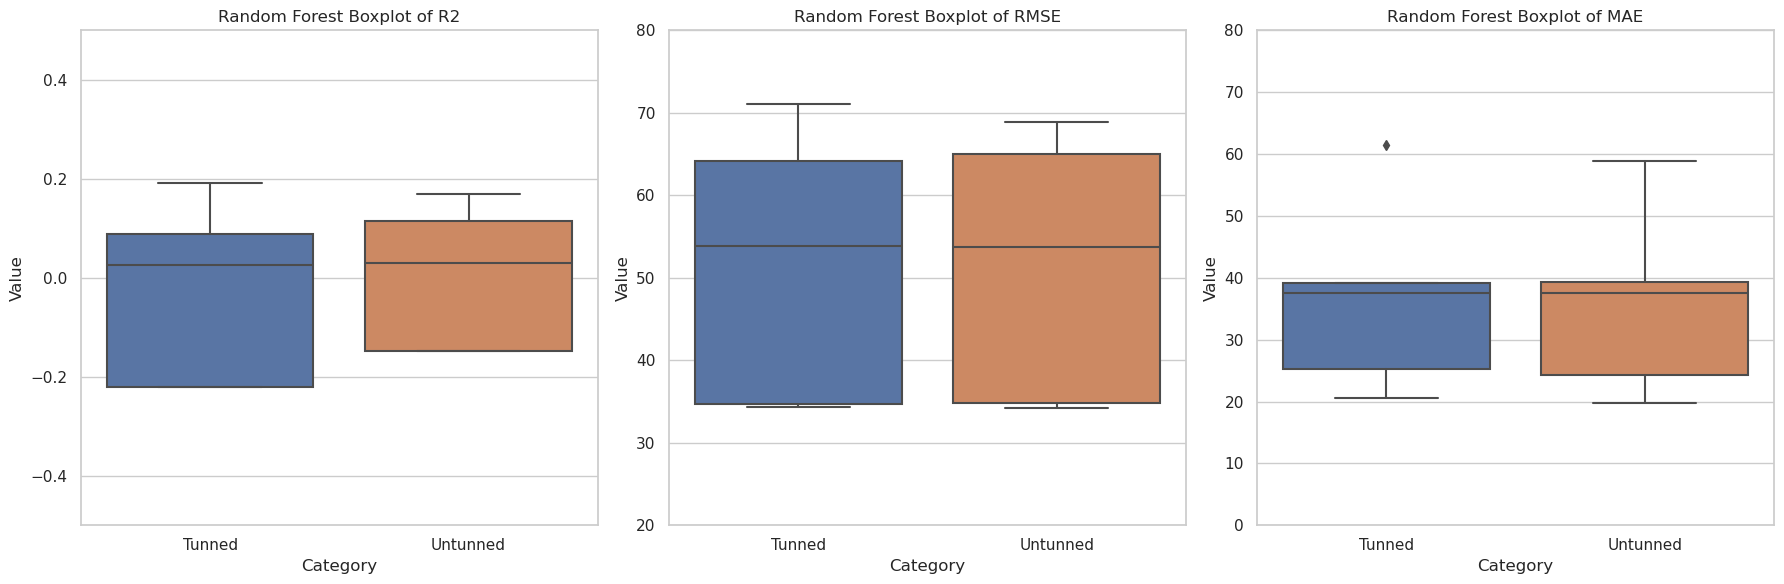

In [65]:
visualize(rf_results, "Random Forest")

### Decision Tree


In [17]:
def get_rmse_errors_cv(X, y, dt, scorer, split=5):
    k_folds = KFold(n_splits = split)
    dt_model = dt
    dt_scores = cross_val_score(dt_model, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")
    results = {
        'Decision Tree': np.sqrt(dt_scores * -1),
        }
    results = pd.DataFrame(results)
    return results

def get_r2_errors_cv(X, y, dt, scorer, split=5):
    k_folds = KFold(n_splits = split)
    dt_model = dt
    dt_scores = cross_val_score(dt_model, X, y.values.ravel(), cv = k_folds, scoring= "r2")
    results = {
        'Decision Tree': dt_scores * -1,
        }
    results = pd.DataFrame(results)
    return results

def get_mae_errors_cv(X, y, dt, scorer, split=5):
    k_folds = KFold(n_splits = split)
    dt_model = dt
    dt_scores = cross_val_score(dt_model, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_absolute_error")
    results = {
        'Decision Tree': dt_scores * -1,
        }
    results = pd.DataFrame(results)
    return results

In [18]:
param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'splitter': ['best', 'random'],
    'max_depth': [None] + list(np.arange(2, 20)),
    'min_samples_split': np.arange(2, 10),
    'min_samples_leaf': np.arange(1, 10),
    'max_features': [None, 'auto', 'sqrt', 'log2'] + list(np.arange(0.1, 1.1, 0.1))
}

dt_model = RandomizedSearchCV(DecisionTreeRegressor()
    ,param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings that are sampled
    cv=5,       # Number of cross-validation folds
    verbose=1,
    random_state=42,
    n_jobs=-1  )
search_dt = dt_model.fit(X_train, y_train)
search_dt.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


{'splitter': 'best',
 'min_samples_split': 5,
 'min_samples_leaf': 6,
 'max_features': 0.6,
 'max_depth': 5,
 'criterion': 'poisson'}

In [19]:
best_params_dt = search_dt.best_params_

In [20]:
dt = DecisionTreeRegressor()
dt.set_params(**search_dt.best_params_)

DecisionTreeRegressor(criterion='poisson', max_depth=5, max_features=0.6,
                      min_samples_leaf=6, min_samples_split=5)

In [21]:
r2_results = get_r2_errors_cv(X, y, dt, "r2", split=5)
print(r2_results)

   Decision Tree
0      21.659536
1      -0.283113
2       0.049437
3       0.092752
4       0.368506


In [22]:
r2_results

,Decision Tree
0,21.659536
1,-0.283113
2,0.049437
3,0.092752
4,0.368506


In [23]:
average_r2_dt = np.mean(r2_results.values.flatten())
average_r2_dt

4.377423599945132

In [24]:
mae_results = get_mae_errors_cv(X, y, dt, "neg_mean_absolute_error")
print(mae_results)

   Decision Tree
0      38.097321
1      54.260279
2      36.692607
3      28.804152
4      57.314948


In [25]:
average_mae_dt = np.mean(mae_results.values.flatten())
average_mae_dt

43.03386160186689

In [26]:
rmse_results = get_rmse_errors_cv(X, y, dt, "neg_mean_squared_error", split=5)
print(rmse_results)

   Decision Tree
0      57.214393
1      49.234118
2      57.809106
3      32.391564
4      71.066090


In [27]:
average_rmse_dt = np.mean(rmse_results.values.flatten())
average_rmse_dt

53.54305413680464

In [28]:
#untuned decision tree
default_dt = DecisionTreeRegressor(random_state=42)
k_folds = KFold(n_splits = 5)

untuned_mae_result_dt = cross_val_score(default_dt, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_absolute_error")
untuned_rmse_result_dt = cross_val_score(default_dt, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")
untuned_r2_result_dt = cross_val_score(default_dt, X, y.values.ravel(), cv = k_folds, scoring= "r2")



In [29]:
average_untuned_mae_dt = np.mean(untuned_mae_result_dt) *-1
average_untuned_rmse_dt = np.mean(np.sqrt(untuned_rmse_result_dt*-1))
average_untuned_r2_dt = np.mean(untuned_r2_result_dt)


In [30]:
dt_results = {
    "Tunned": {"r2": r2_results.to_numpy().flatten(), "rmse": rmse_results.to_numpy().flatten(), "mae": mae_results.to_numpy().flatten()},
    "Untunned": {"r2": untuned_r2_result_dt, "rmse": np.sqrt(untuned_rmse_result_dt*-1), "mae": untuned_mae_result_dt *-1}
}


In [31]:
dt_results

{'Tunned': {'r2': array([21.65953568, -0.28311289,  0.04943699,  0.09275216,  0.36850606]),
  'rmse': array([57.21439297, 49.23411808, 57.80910588, 32.39156351, 71.06609025]),
  'mae': array([38.09732066, 54.26027934, 36.69260749, 28.80415208, 57.31494844])},
 'Untunned': {'r2': array([-32.5429371 ,   0.24764223,  -0.56070465,  -0.07430688,
          -1.39219541]),
  'rmse': array([52.86799173, 47.31203155, 89.14310159, 37.69580313, 99.47377967]),
  'mae': array([36.7692125 , 27.6016125 , 62.166525  , 21.81371875, 82.2075625 ])}}

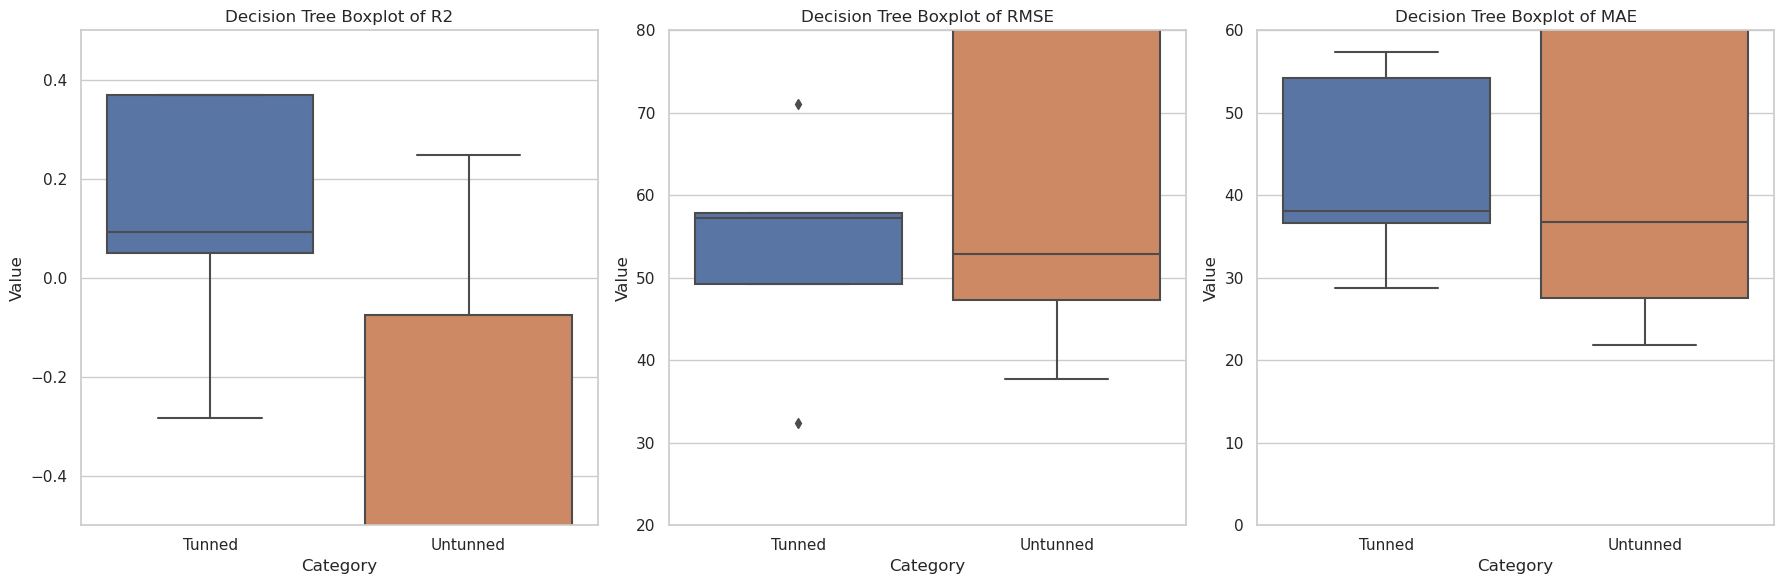

In [32]:
visualize(dt_results, "Decision Tree")

### Xgboost

In [33]:
untunned_xgb_model = XGBRegressor(n_estimators = 200, learning_rate = 0.001)
untunned_xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [34]:
kfold = KFold(n_splits=5)
untunned_r2_results_xgb = cross_val_score(untunned_xgb_model, X, y, cv=kfold, scoring = 'r2')
untunned_rmse_results_xgb = np.sqrt(cross_val_score(untunned_xgb_model, X, y, cv=kfold, scoring = 'neg_mean_squared_error')*1)
untunned_mae_results_xgb = cross_val_score(untunned_xgb_model, X, y, cv=kfold, scoring = 'neg_mean_absolute_error')*1

In [35]:

untunned_pred = untunned_xgb_model.predict(X_test)


In [37]:
untunned_xgb_rmse = np.sqrt(mean_squared_error(y_test, untunned_pred))
print("RMSE : % f" %(untunned_xgb_rmse))

RMSE :  48.079548


In [39]:
untunned_xgb_mae = mean_absolute_error(y_test, untunned_pred)
print('mean absolute score:', untunned_xgb_mae)

mean absolute score: 35.111086785507204


In [40]:
untunned_xgb_r2 = r2_score(y_test, untunned_pred)
print('r2 score:',untunned_xgb_r2)

r2 score: 0.12585421817411602


In [41]:
# Randomized Search hyperparameter
xgb_reg = XGBRegressor()
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_lambda': [0, 0.1, 0.2, 0.3, 0.4]
}

random_search_xgb = RandomizedSearchCV(xgb_reg, param_distributions=param_dist, n_iter=50, scoring='r2', cv=5, verbose=1, random_state=42, n_jobs=-1)
random_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'reg_alpha': [0, 0.1, 0.2, 0.3, 0.4],
                                        'reg_lambda': [0, 0.1, 0.2, 0.3, 0.4],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='r2', verbose=1)

In [42]:
k_folds = KFold(n_splits = 5)
xgb_mae = cross_val_score(random_search_xgb.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_absolute_error") * -1
xgb_r2 = cross_val_score(random_search_xgb.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "r2")
xgb_rmse = np.sqrt(cross_val_score(random_search_xgb.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")*-1)

In [43]:
best_params_xgb = random_search_xgb.best_params_
print("Best parameters found: ", best_params_xgb)

best_model_xgb = random_search_xgb.best_estimator_
tunned_pred = best_model_xgb.predict(X_test)

Best parameters found:  {'subsample': 0.6, 'reg_lambda': 0.2, 'reg_alpha': 0.3, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.8}


In [45]:
tunned_xgb_rmse = np.sqrt(mean_squared_error(y_test, tunned_pred))
print("RMSE : % f" %(tunned_xgb_rmse))
tunned_xgb_mae = mean_absolute_error(y_test, tunned_pred)
print('mean absolute score:', tunned_xgb_mae)
tunned_xgb_r2 = r2_score(y_test, tunned_pred)
print('r2 score:',tunned_xgb_r2)

RMSE :  44.122832
mean absolute score: 33.011986434173586
r2 score: 0.2638100732432651


In [49]:
xgb_results = {
    "Tunned": {"r2": xgb_r2, "rmse": xgb_rmse, "mae": xgb_mae},
    "Untunned": {"r2": untunned_r2_results_xgb, "rmse": untunned_rmse_results_xgb, "mae": untunned_mae_results_xgb}
}
xgb_results

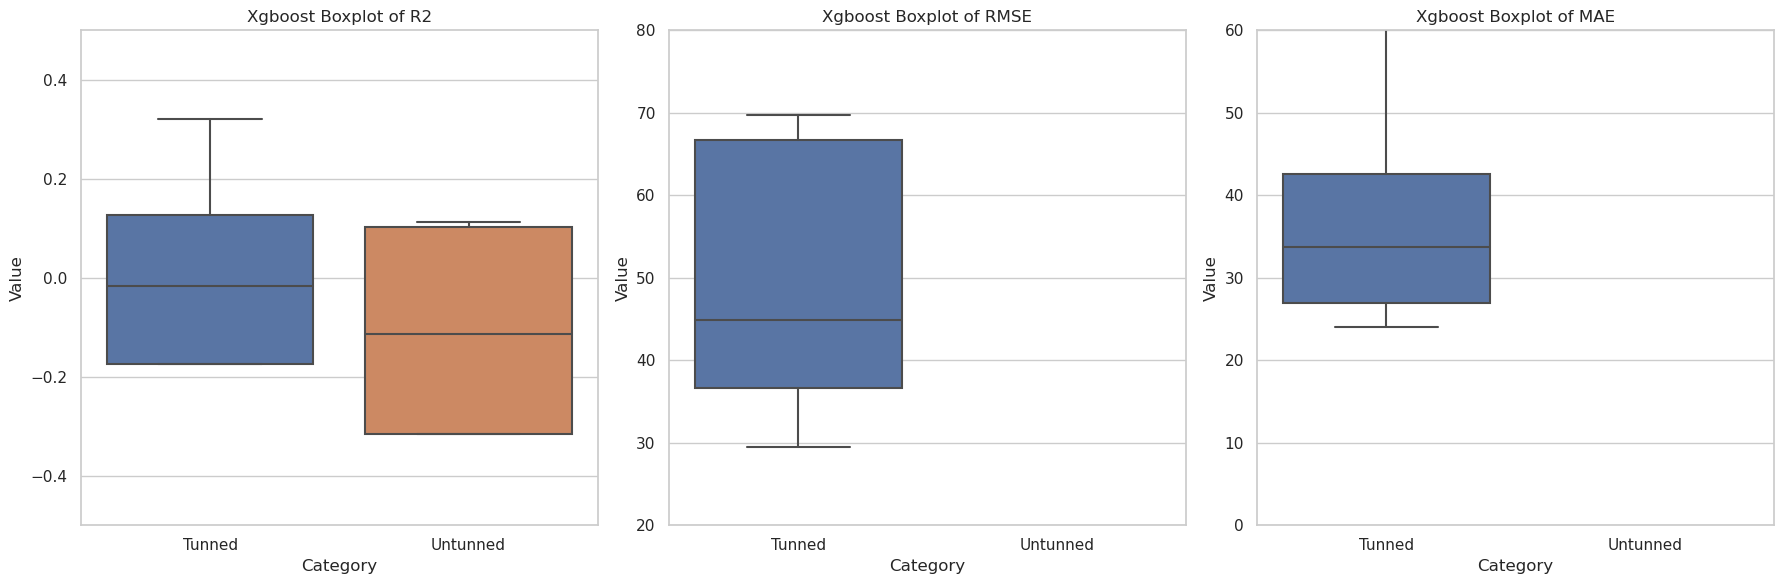

In [50]:
visualize(xgb_results, "Xgboost")

### Gradient Boost

In [92]:
 #Instantiate Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
gbr = GradientBoostingRegressor(loss='absolute_error',
                                learning_rate=0.01,
                                n_estimators=1000,
                                max_depth = 6,
                                random_state = 42,
                                max_features = 5)

# Fit to training set
gbr.fit(X_train, y_train)

# Predict on test set
y_pred = gbr.predict(X_test)

# test set RMSE
untunned_test_rmse_gb = mean_squared_error(y_test, y_pred) ** (1 / 2)
untunned_test_r2_gb = r2_score(y_test, y_pred)
untunned_test_mae_gb = mean_absolute_error(y_test, y_pred)
# Print rmse
print('Root mean Square error: {:.2f}'.format(untunned_test_rmse_gb))
print('Mean Absolute error: {:.2f}'.format(untunned_test_mae_gb))
print('r2 score: {:.2f}'.format(untunned_test_r2_gb))

Root mean Square error: 40.78
Mean Absolute error: 25.26
r2 score: 0.37


In [99]:
param_dist = {
    'n_estimators': np.arange(50, 201, 50),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': np.arange(3, 11, 2),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
    'subsample': np.linspace(0.6, 1.0, 5)
}

random_search_gbr = RandomizedSearchCV(
    estimator= GradientBoostingRegressor(),
    scoring=scoring,
    refit="r2",
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    cv=5,  # Number of folds in cross-validation
    random_state=42,
    n_jobs=-1  # Use all available cores
)

random_search_gbr.fit(X_train, y_train)

# Extract the best hyperparameters
best_params_gbr = random_search_gbr.best_params_
print("Best Hyperparameters: ", best_params_gbr)

# Extract cross-validation results
cv_results_gbr = pd.DataFrame(random_search_gbr.cv_results_)


Best Hyperparameters:  {'subsample': 0.9, 'n_estimators': 100, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 7, 'learning_rate': 0.2677777777777778}


In [100]:
k_folds = KFold(n_splits = 5)
tunned_mae_gb = cross_val_score(random_search_gbr.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_absolute_error") * -1
tunned_r2_gb = cross_val_score(random_search_gbr.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "r2")
tunned_rmse_gb = np.sqrt(cross_val_score(random_search_gbr.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")*-1)

In [54]:
gbr_r2 = cv_results_gbr['mean_test_r2'] *-1
mean_gbr_r2 = gbr_r2.mean()
gbr_mae = cv_results_gbr['mean_test_neg_mean_absolute_error'] * -1
mean_gbr_mae = gbr_mae.mean()
gbr_rmse = np.sqrt(cv_results_gbr['mean_test_neg_mean_squared_error'] * -1)
mean_gbr_rmse = gbr_rmse.mean()

In [61]:
gb_results = {
    "Tunned": {"r2": tunned_r2_gb, "rmse": tunned_rmse_gb, "mae": tunned_mae_gb},
    "Untunned": {"r2": test_r2_gb, "rmse": test_rmse_gb, "mae": test_mae_gb}
}
gb_results

{'Tunned': {'r2': array([-4.44395684e+01,  4.38249463e-01,  3.46235556e-03, -1.16883705e-03,
         -5.18360751e-01]),
  'rmse': array([67.38440661, 41.69917473, 71.04800782, 36.44769167, 71.86209411]),
  'mae': array([47.27252444, 32.06271052, 44.78900155, 21.60346217, 60.10801605])},
 'Untunned': {'r2': array([-13.91931148,   0.33198967,   0.08871894,   0.14120819,
          -0.12513746]),
  'rmse': array([35.25872958, 44.58112057, 68.11669205, 33.7033266 , 68.22021517]),
  'mae': array([25.56598725, 33.16324356, 39.67400676, 18.7945624 , 58.68425773])}}

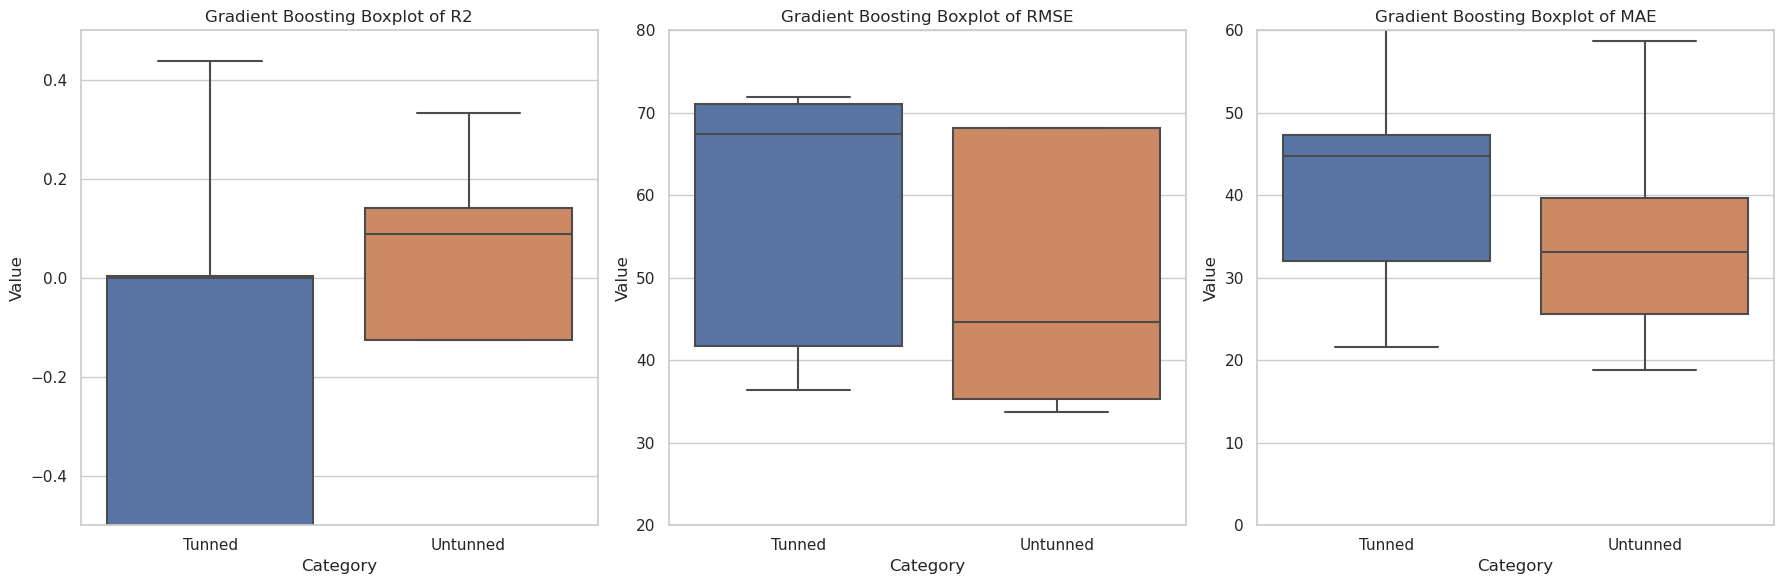

In [62]:
visualize(xgb_results, "Gradient Boosting")

### ANN

In [75]:
# Normalize the data
scaler = StandardScaler()
X_train_scaled =  scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

In [68]:
# Create the model with increased max_iter
scoring = {
    'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False),
    'mae': make_scorer(mean_absolute_error, greater_is_better=False),
    'r2': make_scorer(r2_score)
}
untunned_mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
scores = cross_validate(untunned_mlp, X_train_scaled, y_train, cv=5, scoring=scoring, return_train_score=True)


In [69]:
print("RMSE:", -np.mean(scores['test_rmse']))
print("MAE:", -np.mean(scores['test_mae']))
print("R²:", np.mean(scores['test_r2']))

RMSE: 48.405579389974505
MAE: 35.70849026575733
R²: -0.9683907978339665


In [70]:
untunned_r2_mlp = np.mean(scores['test_r2'])
untunned_rmse_mlp = -np.mean(scores['test_rmse'])
untunned_mae_mlp = -np.mean(scores['test_mae'])


In [77]:
param_grid = {
    'hidden_layer_sizes': [(5,), (10,), (20,), (10, 10), (20, 10)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    # 'alpha': [0.0001, 0.001, 0.01],
    # 'batch_size': [10, 20, 40],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],  # Added learning rate initialization
}

In [78]:
# Create the model with increased max_iter
mlp = MLPRegressor(max_iter=2000)

In [79]:
# Perform Grid Search with threading backend
with parallel_backend('threading'):
    grid = GridSearchCV(estimator=mlp, param_grid=param_grid, n_jobs=-1, cv=5, scoring='r2', return_train_score=True)
    grid_result = grid.fit(X_train_scaled, y_train)

# Summarize the results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
best_params_ann = grid_result.best_params_

Best: -0.15483078191387845 using {'activation': 'logistic', 'hidden_layer_sizes': (10, 10), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'solver': 'adam'}


In [80]:
# Evaluate the best model on the test set
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test_scaled)
mse_ann = mean_squared_error(y_test, y_pred)
mae_ann = mean_absolute_error(y_test, y_pred)
r2_ann = r2_score(y_test, y_pred)
rmse_ann = np.sqrt(mse_ann)
print(f'Test RMSE: {rmse_ann}')
print(f'Test MAE: {mae_ann}')
print(f'Test R2: {r2_ann}')

Test RMSE: 53.65691026965318
Test MAE: 29.544483227264504
Test R2: -0.0887155740100023


In [81]:
k_folds = KFold(n_splits = 5)
tunned_mae_ann = cross_val_score(best_model, X_scaled, y.values.ravel(), cv = k_folds, scoring= "neg_mean_absolute_error") * -1
tunned_r2_ann = cross_val_score(best_model, X_scaled, y.values.ravel(), cv = k_folds, scoring= "r2")
tunned_rmse_ann = np.sqrt(cross_val_score(best_model, X_scaled, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")*-1)

In [82]:
ann_results = {
    "Tunned": {"r2": tunned_r2_ann, "rmse": tunned_rmse_ann, "mae": tunned_mae_ann},
    "Untunned": {"r2": scores['test_r2'], "rmse": -scores['test_rmse'], "mae": -scores['test_mae']}
}
ann_results

{'Tunned': {'r2': array([-0.76362848, -0.04895233, -0.14021052,  0.03047064, -0.80084819]),
  'rmse': array([10.89354462, 55.64605328, 76.54535749, 36.48654391, 86.51145105]),
  'mae': array([ 9.48555669, 26.40511251, 38.52796397, 23.33673797, 62.86797873])},
 'Untunned': {'r2': array([-0.16958752,  0.67014063, -1.67751422,  0.42661669, -4.09160958]),
  'rmse': array([86.53961533, 42.34830504, 39.00174645, 30.25462862, 43.88360151]),
  'mae': array([58.44343015, 30.71474014, 28.36103084, 26.12346546, 34.89978473])}}

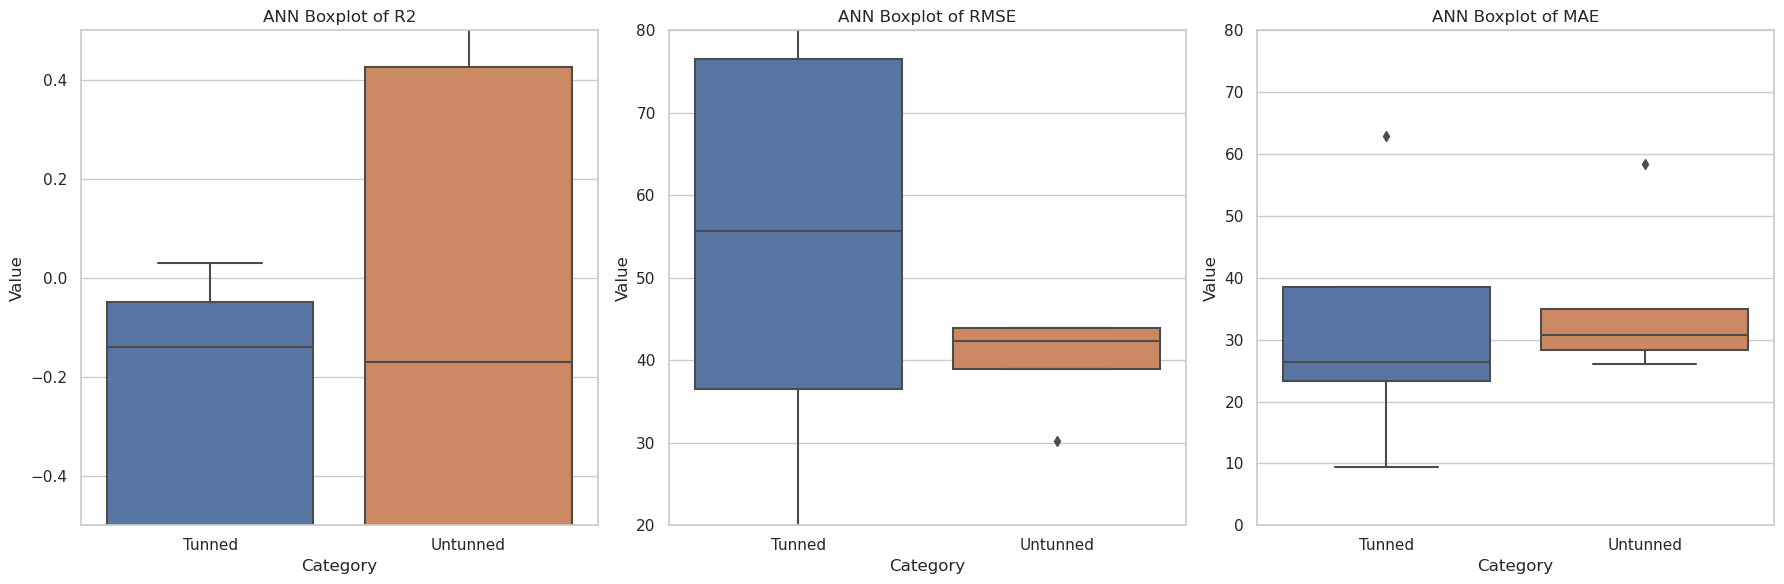

In [83]:
visualize(ann_results, "ANN")

## Results before finetuning

In [101]:
#before fine tuning
untuned_results ={"Scoring": [],
               "random forest":[],
               "decision tree":[],
                "Xgboost": [],
                "gradient boost": [],
                "ann": []
              }
untuned_results["Scoring"].append("r2_score")
untuned_results["random forest"].append(average_untuned_r2_rf)
untuned_results["decision tree"].append(average_untuned_r2_dt)
untuned_results["Xgboost"].append(untunned_xgb_r2)
untuned_results["gradient boost"].append(untunned_test_r2_gb)
untuned_results["ann"].append(untunned_r2_mlp)

untuned_results["Scoring"].append("MAE")
untuned_results["random forest"].append(average_untuned_mae_rf)
untuned_results["decision tree"].append(average_untuned_mae_dt)
untuned_results["Xgboost"].append(untunned_xgb_mae)
untuned_results["gradient boost"].append(untunned_test_mae_gb)
untuned_results["ann"].append(untunned_mae_mlp)

untuned_results["Scoring"].append("RMSE")
untuned_results["random forest"].append(average_untuned_rmse_rf)
untuned_results["decision tree"].append(average_untuned_rmse_dt)
untuned_results["Xgboost"].append(untunned_xgb_rmse)
untuned_results["gradient boost"].append(untunned_test_rmse_gb)
untuned_results["ann"].append(untunned_rmse_mlp)


In [102]:
untuned_results = pd.DataFrame(untuned_results)
untuned_results

,Scoring,random forest,decision tree,Xgboost,gradient boost,ann
0,r2_score,-2.668805,-6.864500,0.125854,0.371110,-0.968391
1,MAE,35.958675,46.111726,35.111087,25.264160,35.708490
2,RMSE,51.330398,65.298542,48.079548,40.780805,48.405579


## Overall finetuned Results

In [86]:
results = {"Scoring": [],
           "random forest":[],
           "decision tree":[],
           "Xgboost":[],
           "Gradient Boost":[],
           "ANN":[]
          }
results["Scoring"].append("r2_score")
results["random forest"].append(mean_rf_r2)
results["decision tree"].append(average_r2_dt)
results["Xgboost"].append(tunned_xgb_r2)
results["Gradient Boost"].append(mean_gbr_r2)
results["ANN"].append(r2_ann)

In [87]:
results["Scoring"].append("MAE")
results["random forest"].append(mean_rf_mae)
results["decision tree"].append(average_mae_dt)
results["Xgboost"].append(tunned_xgb_mae)
results["Gradient Boost"].append(mean_gbr_mae)
results["ANN"].append(mae_ann)

In [88]:
results["Scoring"].append("RMSE")
results["random forest"].append(mean_rf_rmse)
results["decision tree"].append(average_rmse_dt)
results["Xgboost"].append(tunned_xgb_rmse)
results["Gradient Boost"].append(mean_gbr_rmse)
results["ANN"].append(rmse_ann)

In [89]:
df_results = pd.DataFrame(results)
df_results

,Scoring,random forest,decision tree,Xgboost,Gradient Boost,ANN
0,r2_score,0.479291,4.377424,0.263810,0.718557,-0.088716
1,MAE,30.756516,43.033862,33.011986,33.710086,29.544483
2,RMSE,48.843391,53.543054,44.122832,50.517326,53.656910


## Best Parameters

In [90]:
best_params = {
    "ANN":best_params_ann,
    "Random Forest":best_params_rf,
    "Decision Tree":best_params_dt,
    "XgBoost":best_params_xgb,
    "Gradient Boost": best_params_gbr,

}
best_params

{'ANN': {'activation': 'logistic',
  'hidden_layer_sizes': (10, 10),
  'learning_rate': 'constant',
  'learning_rate_init': 0.001,
  'solver': 'adam'},
 'Random Forest': {'max_depth': 8,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 150},
 'Decision Tree': {'splitter': 'best',
  'min_samples_split': 5,
  'min_samples_leaf': 6,
  'max_features': 0.6,
  'max_depth': 5,
  'criterion': 'poisson'},
 'XgBoost': {'subsample': 0.6,
  'reg_lambda': 0.2,
  'reg_alpha': 0.3,
  'n_estimators': 100,
  'max_depth': 4,
  'learning_rate': 0.01,
  'gamma': 0.2,
  'colsample_bytree': 0.8},
 'Gradient Boost': {'subsample': 0.7,
  'n_estimators': 150,
  'min_samples_split': 5,
  'min_samples_leaf': 3,
  'max_depth': 7,
  'learning_rate': 0.07444444444444444}}